This notebook applies Doc2Vec and Scoring fucntion on the consumer reviews to quantify product-level differences.

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Data

Check out [this notebook](https://github.com/liu431/Content-Analysis-Project/blob/master/Data/data_extraction_electronics.ipynb) for getting the Amazon Review Data (2018), transformed the format, and extracted the sample corpus.


Sample data: metadata and reviews of 10 keyboards that have highest reviews in the data 

In [10]:
meta = pd.read_csv('../Data/output_meta.csv')
review = pd.read_csv('../Data/output_review.csv')
review = review[review['reviewText'].notnull()]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
meta

,Unnamed: 0,overall,asin,category,description,title,image,brand,feature,rank,main_cat,date,price,also_buy,also_view,similar_item,tech1,tech2,details,fit
0,92,2567,B000A6PPOK,"['Electronics', 'Computers & Accessories', 'Co...",['USB'],Microsoft Natural Ergonomic Keyboard 4000,['https://images-na.ssl-images-amazon.com/imag...,Microsoft,['Split ergonomic design encourages natural ha...,['>#222 in Computers & Accessories > Computer ...,All Electronics,"September 27, 2017",NaN,"['B00FPAVUHC', 'B0043T7FXE', 'B001F42MKG', 'B0...","['B075GZVD4T', 'B002MMY4WY', 'B00CYX26BC', 'B0...","[{'asin': '', 'href': '', 'name': 'Microsoft N...",NaN,NaN,NaN,NaN
1,191,1805,B00I0S6SK0,"['Electronics', 'Computers & Accessories', 'Co...",['The AZiO Vision keyboard features extra larg...,Azio Vision Backlit USB Keyboard with Large Pr...,['https://images-na.ssl-images-amazon.com/imag...,Azio,['Easy to see large print keys. 2x Larger than...,['>#56 in Computers & Accessories > Computer A...,Computers,"October 21, 2017",$2.54,"['B00ERV026K', 'B0787QZ6WD', 'B075WW7V6W', 'B0...","['B003VAGXWK', 'B00AGI7NKG', 'B007ZUC7DG', 'B0...","[{'asin': '', 'href': '', 'name': 'Azio Vision...",{'Number of USB 2.0 Ports': '1'},"{'Brand Name': 'Azio', 'Item model number': 'K...",NaN,NaN
2,501,1092,B00KF9IVKC,"['Electronics', 'Computers & Accessories', 'Co...",NaN,iPazzPort 3-color Backlit Wireless Mini Keyboa...,['https://images-na.ssl-images-amazon.com/imag...,iPazzPort,['3 in 1 multifunction 2.4ghz mini wireless qw...,['>#82 in Computers & Accessories > Computer A...,Computers,"June 23, 2017",$14.99,"['B07BCC8PK7', 'B06XHY5VXF', 'B0153R2A9I', 'B0...","['B015J6TEN8', 'B00Z81U3YY', 'B017N6J44G', 'B0...","[{'asin': '', 'href': '', 'name': 'iPazzPort 3...",NaN,NaN,NaN,NaN
3,1630,523,B00D9UTZWW,"['Electronics', 'Computers & Accessories', 'La...",NaN,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...",['https://images-na.ssl-images-amazon.com/imag...,IBENZER,['Compatibility - MacBook Air 11 Inch model A1...,['>#259 in Computers & Accessories > Laptop Ac...,Computers,"August 28, 2017",$12.99,"['B01AJVYE9W', 'B00VVLE5CG', 'B007TA1YNQ', 'B0...","['B07L17HNZR', 'B07KQNHKVL', 'B00H0272VQ', 'B0...","[{'asin': '', 'href': '', 'name': 'iBenzer Mac...",NaN,NaN,NaN,NaN
4,1640,521,B00NG8EJOG,"['Electronics', 'Computers & Accessories', 'Ta...",['DUAL MODE CONNECTION 1. BLUETOOTH MODE: Pair...,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",['https://images-na.ssl-images-amazon.com/imag...,Jelly Comb,['FOLDING BLUETOOTH KEYBOARD: Bluetooth 3.0 te...,['>#37 in Computers & Accessories > Tablet Acc...,Computers,"April 27, 2017",$32.99,"['B07G723CB2', 'B079TL2TGY', 'B01HRIDPOA', 'B0...","['B018K5EJCQ', 'B078K1FFCP', 'B01MTVC775', 'B0...","[{'asin': '', 'href': '', 'name': 'Foldable Bl...",NaN,NaN,NaN,NaN
5,2263,418,B00E4TOWR0,"['Electronics', 'Computers & Accessories', 'Co...","[""Get-more-done productivity: Achieve more wit...",HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),['https://images-na.ssl-images-amazon.com/imag...,HP,['Get-more-done productivity: Achieve more wit...,['>#25 in Computers & Accessories > Computer A...,Computers,"July 28, 2017",$14.99,NaN,"['B005EOWBHC', 'B00ZYLMQH0', 'B004YDSPSS', 'B0...","[{'asin': '', 'href': '', 'name': 'HP Wired US...","{'Brand Name': 'HP', 'Series': 'H3C52AA', 'Ite...",NaN,NaN,NaN
6,2547,387,B00O1B59AU,"['Electronics', 'Computers & Accessories', 'Ta...","[""The ZAGG Slim Book wireless Bluetooth keyboa...","ZAGG Slim Book Ultrathin Case, Hinged with Det...",['https://images-na.ssl-images-amazon.com/imag...,ZAGG,"[""Thin: Its ultrathin design is easy to carry ...",['>#188 in Computers & Accessories > Tablet Ac...,Computers,"October 6, 2017",$54.99,"['B00MJX9CFU', 'B00P7TQR3S', 'B00PYMHOG2', 'B0...","['B00MJX9CFU', 'B078883T1C', 'B00X5X1XXW', 'B0...","[{'asin': '', 'href': '', 'name': 'ZAGG Slim B...",{'Screen Size': '9.7 inches'},"{'Brand Name': 'ZAGG', 'Item model number': 'I...",NaN,NaN
7,2620,378,B00LSGKEC4,"['Electronics', 'Computers & Ac

In [11]:
review.head()

,Unnamed: 0,asin,title,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,1,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,2,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN
3,3,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 15, 2018",A2FMMCFQ8702DN,{'Style:': ' Business'},Wickenball,Love it.,Five Stars,1526342400,NaN
4,4,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 12, 2018",A1I8WBJSZIPJE0,{'Style:': ' Business'},B. Stearn,I've had various versions of this keyboard for...,Five Stars,1526083200,NaN


## Doc2Vec

In [121]:
review_agg = review.groupby(['asin', 'title'], as_index=False)[['reviewText']].agg(sum)
review_agg

,asin,title,reviewText
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach..."
1,B004HJDUW0,Monoprice 32ft 10M USB 2.0 A Male to A Female ...,I have a LifeCam VX-5000 HD webcam on the end ...
2,B00D9UTZWW,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...","Don't love the keyboard screen, but the case i..."
3,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...
4,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....
5,B00KF9IVKC,iPazzPort 3-color Backlit Wireless Mini Keyboa...,For $11.99 you can't go wrong. The keyboard ha...
6,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive..."
7,B00NG8EJOG,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",Outstanding little bluetooth keyboard. I'm usi...
8,B00O1B59AU,"ZAGG Slim Book Ultrathin Case, Hinged with Det...",Zagg has really gone downhill in quality. I'v...
9,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...


### Cleaning

In [122]:
review_agg['tokenized_words'] = review_agg['reviewText'].apply(lambda x: 
                                                               lucem_illud_2020.word_tokenize(x))
review_agg['normalized_words'] = review_agg['tokenized_words'].apply(lambda x: 
                                                                     lucem_illud_2020.normalizeTokens(x, lemma=False))

In [149]:
keywords = ['keyboard', 'Microsoft', 'HP', 'MacBook', 'Monoprice', 
            'Azio', 'iPazzPort', 'Redragon', 'Jelly', 'ZAGG']

In [150]:
taggedDocs = []
for index, row in review_agg.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['asin'])
    docKeywords.append(row['title']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
review_agg['TaggedReviews'] = taggedDocs

In [151]:
docKeywords

['keyboard',
 'B0194MC7JG',
 'Wireless Keyboard and Mouse - Jelly Comb K025 Compact 2.4Ghz Wireless Keyboard Mouse - Keyboard and Mouse Combo- Compatible with PC Laptop Windows 7/8/10-Updated (Yellow and Black)']

### Model

In [153]:
dfD2V = gensim.models.doc2vec.Doc2Vec(review_agg['TaggedReviews'], vector_size = 100) #Limiting to 100 dimensions

### Analysis

In [154]:
dfD2V.most_similar(positive = ['feel','great'], negative = ['like'], topn = 1)

[('price', 0.9982938766479492)]

#### Words that are most similar to the whole document

In [155]:
dfD2V.most_similar( [ dfD2V.docvecs['B000A6PPOK']], topn=5) 

[('esc', 0.9445194602012634),
 ('loudest', 0.9021098613739014),
 ('palms', 0.8328696489334106),
 ('elite', 0.8097238540649414),
 ('reaching', 0.8017771244049072)]

In [156]:
dfD2V.most_similar( [ dfD2V.docvecs['B004HJDUW0'] ], topn=5) 

[('receiver', 0.993975043296814),
 ('port', 0.9919992089271545),
 ('os', 0.9847533702850342),
 ('plug', 0.9733117818832397),
 ('recognized', 0.9720518589019775)]

#### Recommend products by keywords

In [157]:
dfD2V.docvecs.most_similar([dfD2V['wireless']], topn=5 )

[('HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA)', 0.9216263294219971),
 ('B00E4TOWR0', 0.9215660691261292),
 ('keyboard', 0.9141351580619812),
 ('Monoprice 32ft 10M USB 2.0 A Male to A Female Active Extension / Repeater Cable use with PlayStation, Xbox, Kinenct, Oculus VR, USB Flash Drive, Card Reader, Hard Drive, Keyboard, Printer, Camera and More!',
  0.8484570980072021),
 ('B004HJDUW0', 0.8481110334396362)]

In [158]:
dfD2V.docvecs.most_similar([ dfD2V['wireless']+dfD2V['keyboard']], topn=5 )

[('keyboard', 0.9874275326728821),
 ('HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA)', 0.9399813413619995),
 ('B00E4TOWR0', 0.9399290084838867),
 ('Foldable Bluetooth Keyboard, Jelly Comb B003B Dual Mode USB Wired & Bluetooth Keyboard with Touchpad Rechargeable for Windows Android Tablet Smartphone Surface and More-Updated (Black)',
  0.783848226070404),
 ('B00NG8EJOG', 0.7819780111312866)]

#### Heatmap: cosine similarities between products

In [159]:
targetDocs = review_agg['asin']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = dfD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dfD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

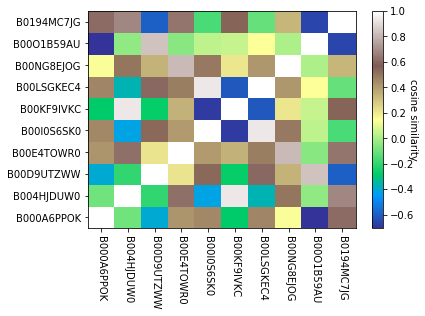

In [160]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

## Scoring function

calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors.

In [183]:
meta['tokenized_words'] = meta['feature'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
meta['normalized_words'] = meta['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))
#meta['tokenized_sents'] = meta['tokenized_words'].apply(lambda x: eval(x))
#meta['normalized_sents'] = meta['normalized_words'].apply(lambda x: eval(x))
meta.head(1)

,Unnamed: 0,overall,asin,category,description,title,image,brand,feature,rank,...,price,also_buy,also_view,similar_item,tech1,tech2,details,fit,tokenized_words,normalized_words
0,92,2567,B000A6PPOK,"['Electronics', 'Computers & Accessories', 'Co...",['USB'],Microsoft Natural Ergonomic Keyboard 4000,['https://images-na.ssl-images-amazon.com/imag...,Microsoft,['Split ergonomic design encourages natural ha...,['>#222 in Computers & Accessories > Computer ...,...,NaN,"['B00FPAVUHC', 'B0043T7FXE', 'B001F42MKG', 'B0...","['B075GZVD4T', 'B002MMY4WY', 'B00CYX26BC', 'B0...","[{'asin': '', 'href': '', 'name': 'Microsoft N...",NaN,NaN,NaN,NaN,"[Split, ergonomic, design, encourages, natural...","[split, ergonomic, design, encourages, natural..."


In [184]:
def adprob(ad, model):
    '''a function to calculate the likelihood of each job description. '''
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [199]:
self_likelihood = []
for i in range(len(meta['asin'])):
    W2V = gensim.models.word2vec.Word2Vec(review_agg['normalized_words'].iloc[i], hs=1, negative=0)
    vocab = W2V.wv.index2word
    self_likelihood.append(adprob(meta['normalized_words'].iloc[i], W2V))

In [200]:
meta['self_likelihood'] = self_likelihood

In [201]:
self_likelihood

[-18.474955,
 -17.892595,
 -16.424152,
 -18.367556,
 -20.032118,
 -19.850481,
 -18.256752,
 -20.395258,
 -19.734833,
 -18.994219]

In [202]:
np.argmin(self_likelihood)

7

In [205]:
meta['title'][np.argmin(self_likelihood)]

'Redragon K502 Gaming Keyboard RGB LED Backlit Illuminated 104 Key Silent Keyboard Karura with Wrist Rest for Windows PC Games (New Improved Version)'

In [203]:
np.argmax(self_likelihood)

2

In [206]:
meta['title'][np.argmax(self_likelihood)]

'iPazzPort 3-color Backlit Wireless Mini Keyboard and Mouse Touchpad for Raspberry Pi 3 Windows, Android, Google, Smart TV, Linux, Mac  KP-810-21SDL-RGB'